<a href="https://colab.research.google.com/github/tomiambro/ap_automatico/blob/tps-tomi/tp1v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.cluster import hierarchy as hc
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA

#Otros 
import warnings
warnings.filterwarnings('ignore')

## Descargar y descomprimir el dataset

El archivo se va a descargar en el path 'root_path'

In [5]:
root_path = 'gdrive/MyDrive/machine_learning/ap_automatico'  # Modificar con el nombre de la carpeta donde vayas a bajar los datos

In [6]:
# download dataset
import requests
from os.path import exists

if not exists(f"{root_path}/dataset_aditional.zip"): 
  url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'
  r = requests.get(url, allow_redirects=True)

  open(f"{root_path}/dataset.zip", 'wb').write(r.content)

In [7]:
# unzip dataset

if not exists(f"{root_path}/dataset_aditional.zip"): 
  import zipfile
  with zipfile.ZipFile(f"{root_path}/dataset.zip", 'r') as zip_ref:
      zip_ref.extractall(root_path)

## Cargamos el dataset en un DataFrame

In [8]:
from sklearn.preprocessing import label_binarize

In [9]:
df_raw = pd.read_csv(f"{root_path}/bank-additional/bank-additional-full.csv", delimiter=';')
df_raw.tail(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,239,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


In [10]:
df_raw.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Revisamos que no falten datos

In [11]:
df_raw.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Descartamos la columna 'duration' segun lo especificado por las notas del dataset:

'*duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*'

In [12]:
# df = df_raw[df_raw['duration'] > 0]
df = df_raw.drop('duration', axis=1)
df.shape, df_raw.shape

((41188, 20), (41188, 21))

In [13]:
df['pdays'] = df['pdays'].replace(999, -1)
df['pdays'].max()

27

### Pasamos las columnas que tienen datos categoricos a variables numericas

In [14]:
# Primero pasamos nuestra 'y'
df.loc[:, 'y'] = label_binarize(df['y'], classes=['no', 'yes'])
df.tail(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,3,-1,1,failure,-1.1,94.767,-50.8,1.028,4963.6,0


In [15]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
cats_vocabs = {}

for col in cat_cols:
  cats_vocabs[col] = pd.Categorical(df[col]).categories
  df.loc[:, col] = pd.Categorical(df[col]).codes

cats_vocabs

{'contact': Index(['cellular', 'telephone'], dtype='object'),
 'day_of_week': Index(['fri', 'mon', 'thu', 'tue', 'wed'], dtype='object'),
 'default': Index(['no', 'unknown', 'yes'], dtype='object'),
 'education': Index(['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate',
        'professional.course', 'university.degree', 'unknown'],
       dtype='object'),
 'housing': Index(['no', 'unknown', 'yes'], dtype='object'),
 'job': Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
        'retired', 'self-employed', 'services', 'student', 'technician',
        'unemployed', 'unknown'],
       dtype='object'),
 'loan': Index(['no', 'unknown', 'yes'], dtype='object'),
 'marital': Index(['divorced', 'married', 'single', 'unknown'], dtype='object'),
 'month': Index(['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep'], dtype='object'),
 'poutcome': Index(['failure', 'nonexistent', 'success'], dtype='object')}

In [16]:
df.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,3.72458,1.172769,3.747184,0.208872,1.071720,0.327425,0.365252,4.230868,2.004613,2.567593,-0.741988,0.172963,0.930101,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,3.59456,0.608902,2.136482,0.406686,0.985314,0.723616,0.481507,2.320025,1.397575,2.770014,1.510327,0.494901,0.362886,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,0.00000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,2.00000,1.000000,3.000000,0.000000,2.000000,0.000000,0.000000,4.000000,2.000000,2.000000,-1.000000,0.000000,1.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,7.00000,2.000000,6.000000,0.000000,2.000000,0.000000,1.000000,6.000000,3.000000,3.000000,-1.000000,0.000000,1.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,11.00000,3.000000,7.000000,2.000000,2.000000,2.000000,1.000000,9.000000,4.000000,56.000000,27.000000,7.000000,2.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


## EDA

### Heatmap

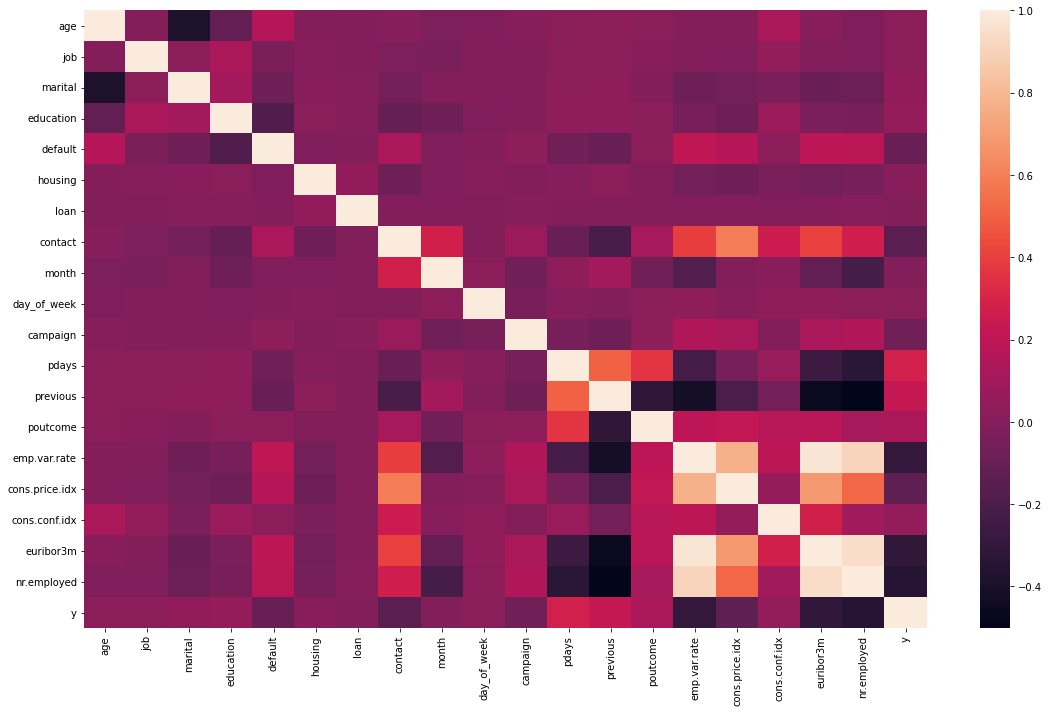

In [17]:
plt.figure(figsize=(16,10))
sns.heatmap(df.corr())
plt.tight_layout()

### Boxplot

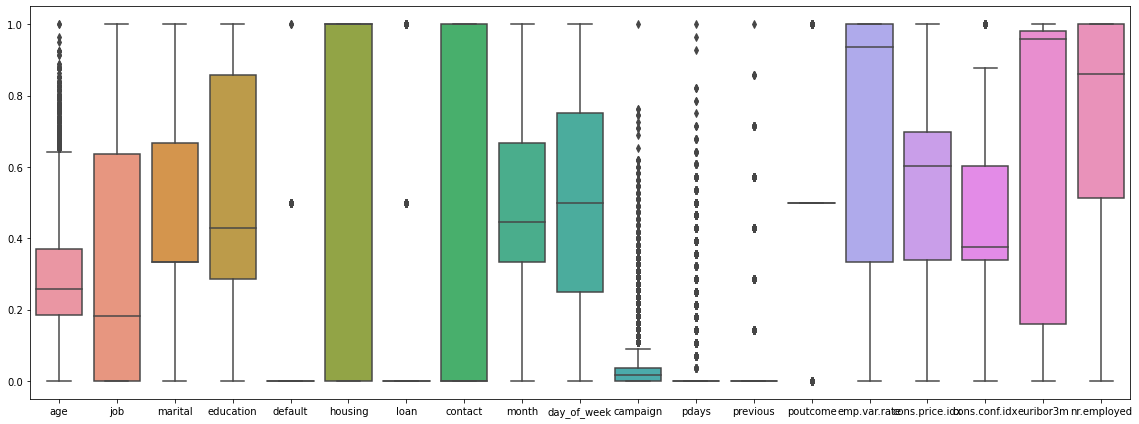

In [18]:
scal = MinMaxScaler()
df_normal = scal.fit_transform(df.drop('y', axis=1))
cols = df.columns
cols = cols.drop('y')
df_normal = pd.DataFrame(df_normal, columns=cols)

plt.figure(figsize=(16,6))
sns.boxplot(data=df_normal)
plt.tight_layout()
plt.show()

<Figure size 1152x1224 with 0 Axes>

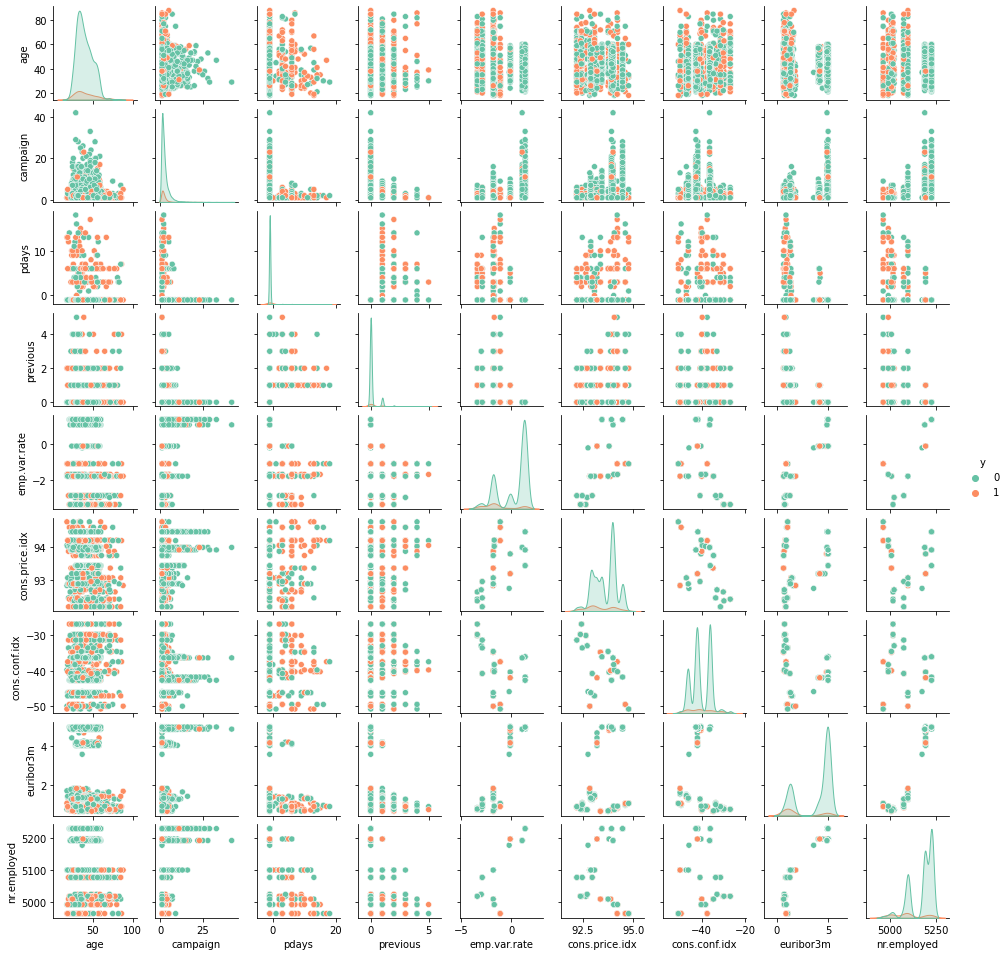

In [19]:
plt.figure(figsize=(16,17))
g = sns.pairplot(data=df.drop(cat_cols, axis=1).sample(frac=0.1, random_state=42), hue='y', palette='Set2', height=1.5)

g.tight_layout()
plt.show()

In [20]:
scal = StandardScaler()
df_scal = scal.fit_transform(df.drop('y', axis=1))

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scal)
xpca = pd.DataFrame(df_pca)

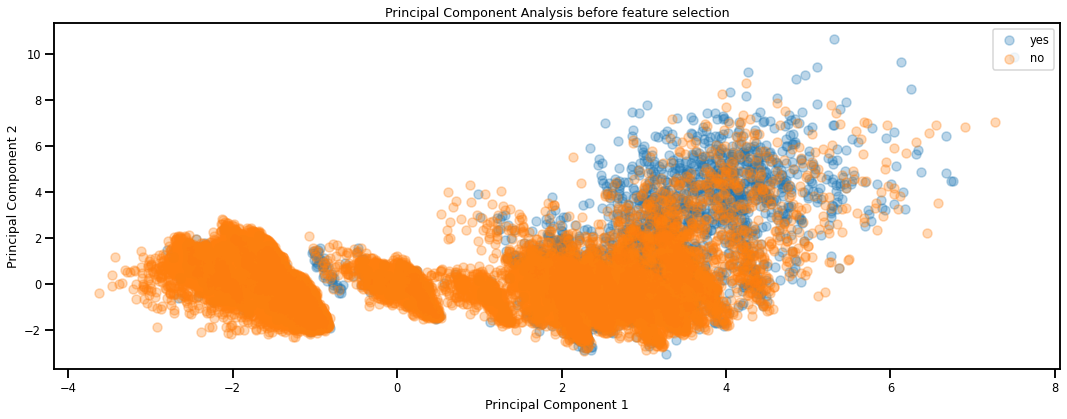

In [21]:
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))

plt.scatter(xpca.loc[(df['y'] == 1).ravel(),0],xpca.loc[(df['y'] == 1).ravel(),1], alpha = 0.3, label = 'yes')
plt.scatter(xpca.loc[(df['y'] == 0).ravel(),0],xpca.loc[(df['y'] == 0).ravel(),1], alpha = 0.3, label = 'no')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

A simple vista no parecen ser linealmente separables

## Entrenamos algunos modelos de Clasificacion

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve

### Revisamos el balance entre clases

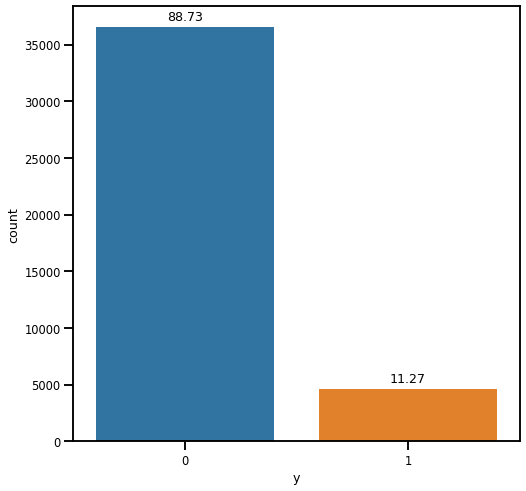

In [23]:
plt.figure(figsize=(8,8))
splot = sns.countplot(x='y', data=df)

for p in splot.patches:
    splot.annotate(format(p.get_height()/df.shape[0]*100, '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

Dado que hay un claro desbalance elegimos las metricas de area bajo la curva ROC y el valor F1 para una correcta interpretacion de la utilidad del modelo.

### Particionamos el dataset en train y test

In [24]:
X = df.drop('y', axis=1)
y = df['y']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

Definimos los modelos que vamos a entrenar

In [25]:
ytests = {}
ypreds = {}
m = {}

res = pd.DataFrame({'model':[], 'roc validation':[], 'roc test':[], 'f1 test':[]})

models = {
        'Logistic Regression': LogisticRegression(n_jobs = -1, random_state=1, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(300, n_jobs = -1, random_state=1, class_weight='balanced'),
        'SVC': SVC(random_state=1, class_weight='balanced'),
        'KNNeighbors': KNeighborsClassifier(n_jobs = -1),
        'LDA': LinearDiscriminantAnalysis()
}

### Modelo de base

In [26]:
scal = MinMaxScaler()
xtrain_scal = scal.fit_transform(xtrain)
xtest_scal = scal.transform(xtest)

In [27]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier()
scores = cross_val_score(dc, xtrain_scal, ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
dc.fit(xtrain_scal, ytrain)
ypred = dc.predict(xtest_scal)
res = res.append({'model': 'Baseline', 'roc validation': scores.mean(), 'roc test': roc_auc_score(ytest, ypred), 'f1 test': f1_score(ytest, ypred)}, ignore_index=True)
res

,model,roc validation,roc test,f1 test
0,Baseline,0.498332,0.491939,0.097455


In [28]:
def train_models(X, y, xtest, ytest, title=''):
  res = []
  
  for name, model in models.items():
    print(name)
    ytests[f'{name} {title}'] = ytest
    # Model training with cross validation
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
    model.fit(X, y)
    
    ypred = model.predict(xtest)
    roc = roc_auc_score(ytest, ypred)
    ypreds[f'{name} {title}'] = ypred
    m[f'{name} {title}'] = model
    
    # Save the results to a dataframe
    # res = res.append(, ignore_index=True)
    res.append({'model': f'{name} {title}', 'roc validation': scores.mean(), 'roc test': roc, 'f1 test': f1_score(ytest, ypred)})
  return res

In [29]:
results = train_models(xtrain_scal, ytrain, xtest_scal, ytest, 'MinMax')
res = res.append(results, ignore_index=True)

Logistic Regression
Random Forest
SVC
KNNeighbors
LDA


In [30]:
res.sort_values('f1 test', ascending=False)

,model,roc validation,roc test,f1 test
3,SVC MinMax,0.774910,0.751365,0.465204
1,Logistic Regression MinMax,0.783605,0.742217,0.436975
5,LDA MinMax,0.775870,0.661788,0.430521
2,Random Forest MinMax,0.778856,0.632252,0.386872
4,KNNeighbors MinMax,0.715987,0.616244,0.352688
0,Baseline,0.498332,0.491939,0.097455


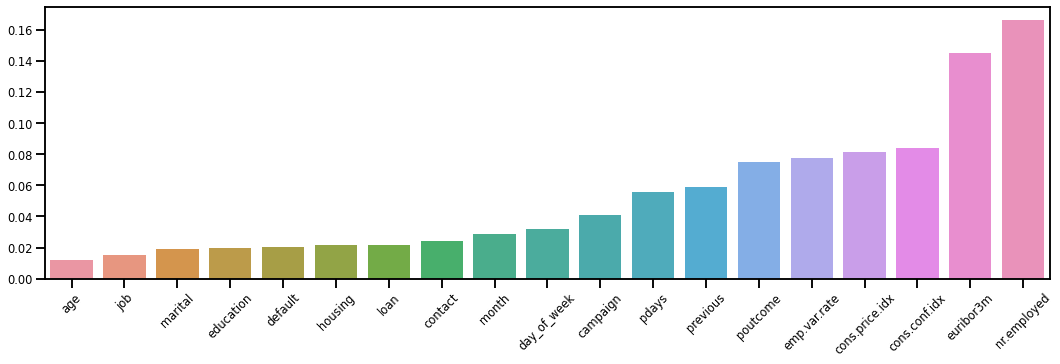

In [31]:
plt.figure(figsize=(18,5))
sns.barplot(df.columns.drop('y'), np.sort(m['Random Forest MinMax'].feature_importances_))
plt.xticks(rotation=45)
plt.show()

In [32]:
df_drop = df.drop(['age', 'job', 'marital'], axis=1)

X = df_drop.drop('y', axis=1)
y = df_drop['y']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

scal = MinMaxScaler()
xtrain_scal = scal.fit_transform(xtrain)
xtest_scal = scal.transform(xtest)

In [33]:
results = train_models(xtrain_scal, ytrain, xtest_scal, ytest, 'MinMax Drop')
res = res.append(results, ignore_index=True)

Logistic Regression
Random Forest
SVC
KNNeighbors
LDA


In [34]:
res.sort_values('f1 test', ascending=False)

,model,roc validation,roc test,f1 test
8,SVC MinMax Drop,0.776437,0.754519,0.473441
3,SVC MinMax,0.774910,0.751365,0.465204
1,Logistic Regression MinMax,0.783605,0.742217,0.436975
6,Logistic Regression MinMax Drop,0.783648,0.741886,0.434361
10,LDA MinMax Drop,0.775559,0.662984,0.433002
5,LDA MinMax,0.775870,0.661788,0.430521
2,Random Forest MinMax,0.778856,0.632252,0.386872
9,KNNeighbors MinMax Drop,0.718426,0.632302,0.386111
7,Random Forest MinMax Drop,0.739213,0.640494,0.357468
4,KNNeighbors MinMax,0.715987,0.616244,0.352688


### Probamos one hot encoding

In [40]:
df_aux = df_raw.drop(['age', 'job', 'marital'], axis=1)

df_aux.loc[:, 'y'] = label_binarize(df_aux['y'], classes=['no', 'yes'])

df_one = pd.get_dummies(df_aux)

In [41]:
X = df_one.drop('y', axis=1)
y = df_one['y']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

scal = MinMaxScaler()
xtrain_scal = scal.fit_transform(xtrain)
xtest_scal = scal.transform(xtest)

In [42]:
results = train_models(xtrain_scal, ytrain, xtest_scal, ytest, 'MinMax Drop OneHot')
res = res.append(results, ignore_index=True)

Logistic Regression
Random Forest
SVC
KNNeighbors
LDA


In [43]:
res.sort_values('f1 test', ascending=False)

,model,roc validation,roc test,f1 test
13,SVC MinMax Drop OneHot,0.932345,0.865417,0.583304
11,Logistic Regression MinMax Drop OneHot,0.936813,0.859491,0.579659
15,LDA MinMax Drop OneHot,0.933663,0.735897,0.564073
12,Random Forest MinMax Drop OneHot,0.939342,0.715297,0.535606
8,SVC MinMax Drop,0.776437,0.754519,0.473441
3,SVC MinMax,0.774910,0.751365,0.465204
1,Logistic Regression MinMax,0.783605,0.742217,0.436975
14,KNNeighbors MinMax Drop OneHot,0.820340,0.657314,0.436412
6,Logistic Regression MinMax Drop,0.783648,0.741886,0.434361
10,LDA MinMax Drop,0.775559,0.662984,0.433002


### Matriz de confusion del mejor modelo

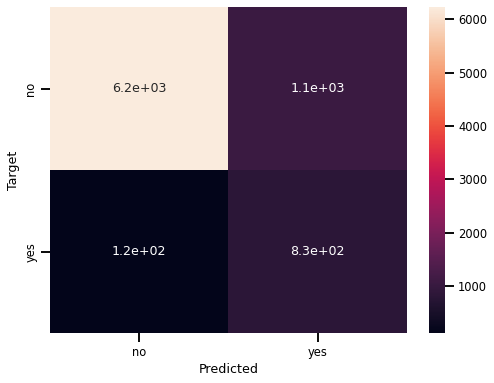

In [45]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(ytests['SVC MinMax Drop OneHot'], ypreds['SVC MinMax Drop OneHot'])
df_cm = pd.DataFrame(cm, index = ['no', 'yes'], columns = ['no', 'yes'])

sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted') # x-axis label with fontsize 15
plt.ylabel('Target') # y-axis label with fontsize 15
plt.show()

## Entrenamos algunos modelos de Regresion

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
ytests = {}
ypreds = {}
m = {}

res = pd.DataFrame({'model':[], 'r2 validation':[], 'r2 test':[], 'mse test':[]})

models = {
        'Linear Regression': LinearRegression(n_jobs = -1),
        'Random Forest': RandomForestRegressor(300, n_jobs = -1, random_state=1),
        'SVR': SVR(),
        'KNNeighbors': KNeighborsRegressor(n_jobs = -1)
}

In [ ]:
def train_models(X, y, xtest, ytest, title=''):
  res = []
  
  for name, model in models.items():
    print(name)
    ytests[f'{name} {title}'] = ytest
    # Model training with cross validation
    scores = cross_val_score(model, X, y, cv=5, scoring='r2', n_jobs=-1)
    model.fit(X, y)
    
    ypred = model.predict(xtest)
    r2 = r2_score(ytest, ypred)
    ypreds[f'{name} {title}'] = ypred
    m[f'{name} {title}'] = model
    
    # Save the results to a dataframe
    # res = res.append(, ignore_index=True)
    res.append({'model': f'{name} {title}', 'r2 validation': scores.mean(), 'r2 test': r2, 'mse test': mean_squared_error(ytest, ypred)})
  return res

In [ ]:
df_r = pd.concat([df, df_raw['duration']], axis=1)
df_r.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duration
41183,73,5,1,5,0,2,0,0,7,0,1,-1,0,1,-1.1,94.767,-50.8,1.028,4963.6,1,334
41184,46,1,1,5,0,0,0,0,7,0,1,-1,0,1,-1.1,94.767,-50.8,1.028,4963.6,0,383
41185,56,5,1,6,0,2,0,0,7,0,2,-1,0,1,-1.1,94.767,-50.8,1.028,4963.6,0,189
41186,44,9,1,5,0,0,0,0,7,0,1,-1,0,1,-1.1,94.767,-50.8,1.028,4963.6,1,442
41187,74,5,1,5,0,2,0,0,7,0,3,-1,1,0,-1.1,94.767,-50.8,1.028,4963.6,0,239


In [ ]:
X = df_r.drop('duration', axis=1)
y = df_r['duration']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

scal = MinMaxScaler()
xtrain_scal = scal.fit_transform(xtrain)
xtest_scal = scal.transform(xtest)

In [ ]:
from sklearn.dummy import DummyRegressor
dc = DummyRegressor()
scores = cross_val_score(dc, xtrain_scal, ytrain, cv=5, scoring='r2', n_jobs=-1)
dc.fit(xtrain_scal, ytrain)
ypred = dc.predict(xtest_scal)
res = res.append({'model': 'Baseline', 'r2 validation': scores.mean(), 'r2 test': r2_score(ytest, ypred), 'mse test': mean_squared_error(ytest, ypred)}, ignore_index=True)
res

,model,r2 validation,r2 test,mse test
0,Baseline,-0.000091,-0.000126,66478.574694


In [ ]:
results = train_models(xtrain_scal, ytrain, xtest_scal, ytest, 'MinMax')
res = res.append(results, ignore_index=True)

Linear Regression
Random Forest
SVR
KNNeighbors


In [ ]:
res.sort_values('mse test', ascending=True)

,model,r2 validation,r2 test,mse test
2,Random Forest MinMax,0.177614,0.190332,53818.793980
1,Linear Regression MinMax,0.186253,0.185270,54155.290228
4,KNNeighbors MinMax,0.112047,0.117450,58663.281957
3,SVR MinMax,0.077421,0.091788,60369.038433
0,Baseline,-0.000091,-0.000126,66478.574694
